# 004.001 EDA - Results

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from pandas.plotting import parallel_coordinates

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

fn = '2007-2008__2017-2018.csv'
EDA_FP = PROJECT_DIR / 'data' / 'sample' / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

## Load Sample Data

Sample Data: Bundesliga Seasons 2007-2008 to 2014-2015

In [2]:
df_orig = pd.read_csv(EDA_FP, parse_dates=['date'])
df_orig = df_orig[~df_orig['season'].isin(['2015-2016', '2016-2017', '2017-2018'])]
cols = ['season', 'date', 'h', 'a', 'h_ftGoals', 'a_ftGoals', 'result']
df_orig = df_orig[cols].sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_orig.head(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
0,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,draw
1,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,hwin


In [3]:
df_orig.tail(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
2446,2014-2015,2015-05-23,hoffenheim,hertha-berlin,2.0,1.0,hwin
2447,2014-2015,2015-05-23,paderborn,stuttgart,1.0,2.0,awin


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 7 columns):
season       2448 non-null object
date         2448 non-null datetime64[ns]
h            2448 non-null object
a            2448 non-null object
h_ftGoals    2448 non-null float64
a_ftGoals    2448 non-null float64
result       2448 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 134.0+ KB


## Proportion of Results

In [5]:
df = df_orig.copy(deep=True)
print(f'n_games {len(df)}')
results = (df['result'].value_counts()/len(df['result'])).sort_index(ascending=False)
results.index=['Home Win', 'Draw', 'Away Win']
print(results, '\n')

n_games 2448
Home Win    0.455474
Draw        0.246732
Away Win    0.297794
Name: result, dtype: float64 



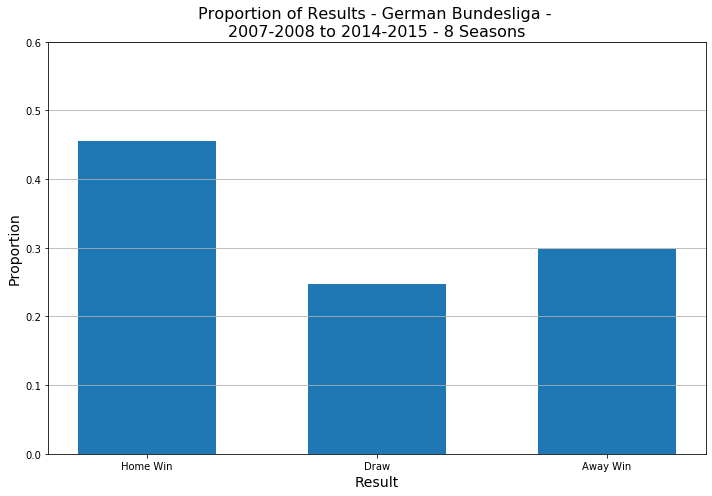

In [6]:
seasons = df['season'].unique()
fig, ax = plt.subplots(figsize=(10,7))

ax.bar(results.index, results.values, width=0.6)

ax.set_ylim(0, 0.6)
ax.set_title(f'Proportion of Results - German Bundesliga - \n{seasons[0]} to {seasons[-1]} - {len(seasons)} Seasons', fontsize=16)
ax.set_xlabel('Result', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.yaxis.grid()
plt.tight_layout()

plt.savefig(SAVED_IMAGES_DIR / 'eda-proportion-of-results-barplot.PNG')
plt.show();

## Variation in Proportion of Results

In [7]:
df = df_orig.copy(deep=True)
season_results_props = []
for season in df['season'].unique():
    season_df = df[df['season'] == season]
    props = pd.DataFrame(season_df['result'].value_counts()/ len(season_df['result'])).sort_index(ascending=False)
    props['season'] = season
    season_results_props.append(props)

props = pd.DataFrame(pd.concat(season_results_props, axis=0)).reset_index()
props.columns = ['result', 'proportion', 'season']
props['result'] = props['result'].map({'hwin': 'Home Win', 'draw': 'Draw', 'awin': 'Away Win'})
props.head()

,result,proportion,season
0,Home Win,0.467320,2007-2008
1,Draw,0.254902,2007-2008
2,Away Win,0.277778,2007-2008
3,Home Win,0.480392,2008-2009
4,Draw,0.241830,2008-2009


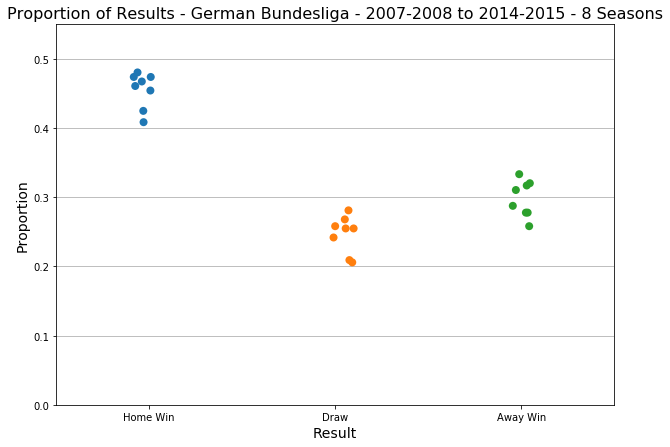

In [8]:
# sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.stripplot(x=props["result"], y=props['proportion'], size=8)
ax.set_title(f'Proportion of Results - German Bundesliga - {seasons[0]} to {seasons[-1]} - {len(seasons)} Seasons', fontsize=16)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xlabel('Result', fontsize=14)
ax.set_ylim(0, 0.55)
ax.yaxis.grid()

plt.savefig(SAVED_IMAGES_DIR / 'eda-proportion-of-results-scatterplot.PNG')
plt.show();

In [9]:
props2 = props.pivot_table(index=['season'], columns='result')
props2.columns = props2.columns.droplevel().rename(None)
props2 = props2.reset_index()
props2.columns
props2 = props2[['season', 'Home Win', 'Draw', 'Away Win']]
props2.head()

,season,Home Win,Draw,Away Win
0,2007-2008,0.467320,0.254902,0.277778
1,2008-2009,0.480392,0.241830,0.277778
2,2009-2010,0.408497,0.281046,0.310458
3,2010-2011,0.460784,0.205882,0.333333
4,2011-2012,0.454248,0.258170,0.287582


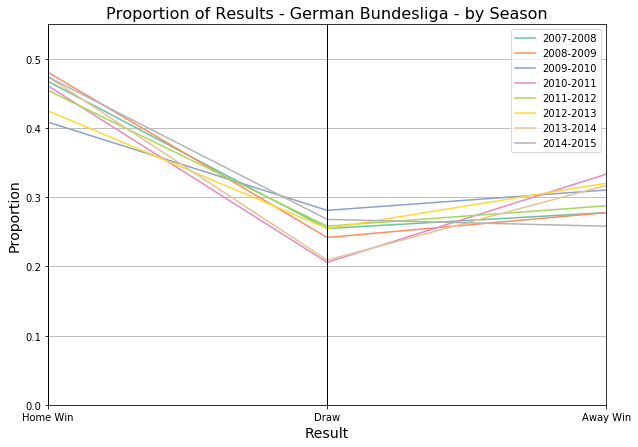

In [10]:
fig, ax = plt.subplots(figsize=(10,7)) 

parallel_coordinates(props2, 'season', colormap=plt.get_cmap("Set2"), ax=ax)
ax.set_ylim(0, 0.55)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xlabel('Result', fontsize=14)
ax.set_title(f'Proportion of Results - German Bundesliga - by Season', fontsize=16)

plt.savefig(SAVED_IMAGES_DIR / 'eda-proportion-of-results-parallel-lineplot.PNG')
plt.show()

It looks like there is a single season in 8 where the number of Away Wins was lower than the number of Draws, and the diferrence in proportions was -0.009804

In [11]:
props2['away subtract draw'] = props2['Away Win'].subtract(props2['Draw'])
props2

,season,Home Win,Draw,Away Win,away subtract draw
0,2007-2008,0.467320,0.254902,0.277778,0.022876
1,2008-2009,0.480392,0.241830,0.277778,0.035948
2,2009-2010,0.408497,0.281046,0.310458,0.029412
3,2010-2011,0.460784,0.205882,0.333333,0.127451
4,2011-2012,0.454248,0.258170,0.287582,0.029412
5,2012-2013,0.424837,0.254902,0.320261,0.065359
6,2013-2014,0.473856,0.209150,0.316993,0.107843
7,2014-2015,0.473856,0.267974,0.258170,-0.009804


In [12]:
props2['away subtract draw'].mean()

0.05106209150326797

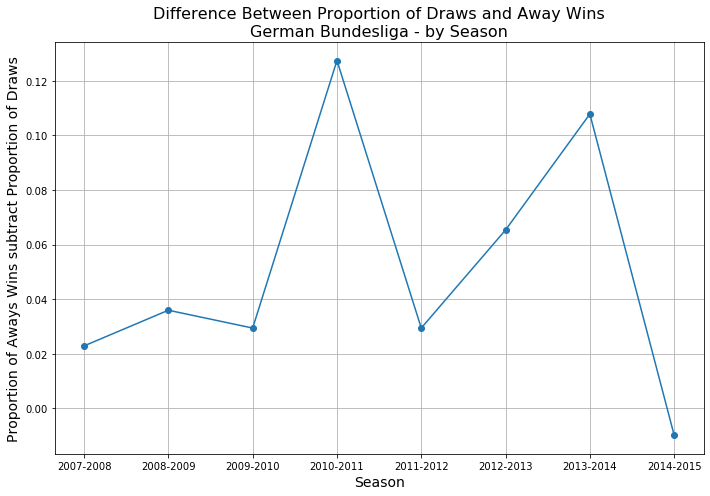

In [13]:
fig, ax = plt.subplots(figsize=(10,7)) 

ax.plot(props2['season'], props2['away subtract draw'], '-o')
ax.set_xlabel('Season', fontsize=14)
ax.set_ylabel('Proportion of Aways Wins subtract Proportion of Draws', fontsize=14)
ax.set_title(f'Difference Between Proportion of Draws and Away Wins\nGerman Bundesliga - by Season', fontsize=16)
ax.xaxis.grid()
ax.yaxis.grid()
plt.tight_layout()

plt.savefig(SAVED_IMAGES_DIR / 'eda-diff-away-draw-proportion-lineplot.PNG')
plt.show();

## Comments

+ If I were forced to guess, I suspect there is a positive bias; the proportion of Away Wins tend to be slightly higher - about 5% - than the proportion of Draws
+ Strong Home Field Advantage - Home Wins occur at about twice the rate of away wins or draws
+ From season to season the range of %s of each results seems to say within about a 0.10 band